In [1]:
import lightning
import torch
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from adaptive_dg.datasets import SimpsonDataset

# Simpson's Paradox Dataset

In [2]:
sns.set_style("whitegrid")

In [3]:
color1 = "#96bf04"
color2 = "#2d04bf"
color3 = "#bf8b04"
color4 = "#bf0496"
color5 = "#710000"

In [4]:
palette = [color1, color2, color3, color4, color5]

In [5]:
SimpsonDataset.n_domains = 5
SimpsonDataset.n_samples = 10_000
dataset = SimpsonDataset("data")

Replacing existing dataset in data.


In [6]:
df = pd.DataFrame({
    "Feature": dataset.data.squeeze().tolist(),
    "Regression Target": dataset.targets.squeeze().tolist(),
    "Domain": (dataset.domains.argmax(dim=1) + 1).tolist(),
})

df.head()

,Feature,Regression Target,Domain
0,-0.290908,9.348645,1
1,0.703825,10.748417,1
2,-0.168205,10.977276,1
3,-0.044723,9.952372,1
4,-0.826780,8.987065,1


In [0]:
mask = dataset.domains.argmax(dim=1) == 0

/tmp/ipykernel_711049/1921805344.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 480x480 with 0 Axes>

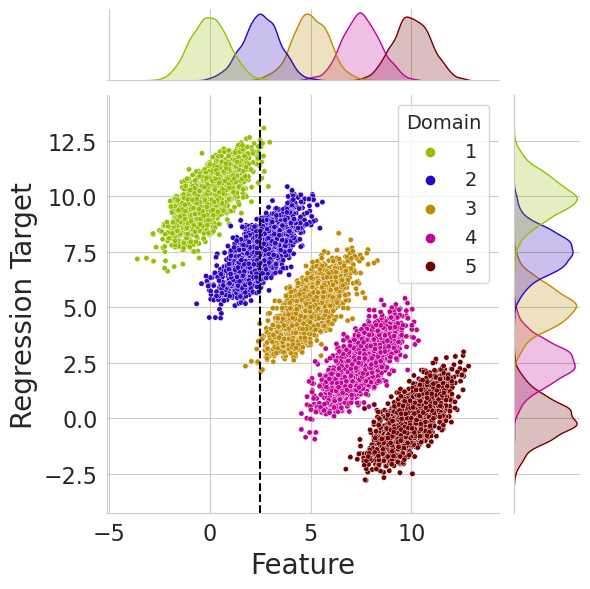

In [24]:
fig = plt.figure(figsize=plt.figaspect(1.0))

sns.jointplot(df, x="Feature", y="Regression Target", hue="Domain", s=15, lw=0, palette=palette)

plt.axvline(2.5, color="black", linestyle="--")

# make ticks bigger
plt.tick_params(axis="both", which="major", labelsize=16)

plt.legend(title="Domain", title_fontsize=14, fontsize=14)

plt.xlabel("Feature", fontsize=20)
plt.ylabel("Regression Target", fontsize=20)

plt.tight_layout()
plt.savefig("figures/simpson.png", dpi=150)
plt.show()

# Environment Classification Accuracy Benefit By Mean Separation

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm, trange

from adaptive_dg.datasets import SimpsonDataset, SetDataset, MultiDomainDataset
from adaptive_dg.models.set_encoders.set_encoder import SingleBlockSetEncoder as SetEncoder
from adaptive_dg.models.set_encoders.mean import Mean

In [6]:
encoder_hparams = {
    "Multi-Head Attention": dict(
        input_dims=64,
        output_dims=64,
        layer_widths=[64, 64, 64],
        output_set_size=4,
        pooling_method="attention",
        pooling_kwargs=dict(heads=8),
        flatten=False,
    ),
    "TopK": dict(
        input_dims=64,
        output_dims=64,
        layer_widths=[64, 64, 64],
        output_set_size=4,
        pooling_method="topk",
        pooling_kwargs=dict(),
        flatten=False,
    ),
    "Mean": dict(
        input_dims=64,
        output_dims=64,
        layer_widths=[64, 64, 64],
        output_set_size=1,
        pooling_method="mean",
        pooling_kwargs=dict(),
        flatten=False,
    ),
}

In [7]:
SimpsonDataset.n_domains = 2
SimpsonDataset.n_samples = 10_000
SimpsonDataset.all_domains = [str(i) for i in range(SimpsonDataset.n_domains)]

In [8]:
results = pd.DataFrame()

In [9]:
def train_baseline(dataset, baseline, in_projector, out_projector, n_epochs=100, batch_size=128):
    network = nn.Sequential(
        in_projector,
        baseline,
        out_projector,
    ).cuda()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
    
    progress_bar = tqdm(range(n_epochs))
    
    for epoch in progress_bar:
        for batch in dataloader:
            optimizer.zero_grad()
            
            features, targets, domains = batch
            predictions = network(features.cuda()).cpu()
            
            loss = nn.functional.cross_entropy(predictions, domains.float())
            
            progress_bar.set_description(f"Loss: {loss.item():.4f}")
            
            loss.backward()
            
            optimizer.step()
    
    predictions = []
    targets = []
    
    for batch in dataloader:
        features, target, domain = batch
        predictions.append(network(features.cuda()).cpu())
        targets.append(domain)
    
    predictions = torch.cat(predictions, dim=0).argmax(dim=1)
    targets = torch.cat(targets, dim=0).argmax(dim=1)
    
    accuracy = (predictions == targets).float().mean(0).item()
    
    return accuracy

In [10]:
def train_encoder(dataset, encoder, in_projector, out_projector, n_epochs=100, batch_size=128, set_size=16):
    network = nn.Sequential(
        in_projector,
        encoder,
        Mean(1),
        nn.Flatten(),
        out_projector,
    ).cuda()
    
    dataset = SetDataset(dataset, set_size=set_size)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
    
    progress_bar = tqdm(range(n_epochs))
    
    for epoch in progress_bar:
        for batch in dataloader:
            optimizer.zero_grad()
            
            features, set_features, targets, domains = batch
            predictions = network(set_features.cuda()).cpu()
            
            loss = nn.functional.cross_entropy(predictions, domains.float())
            
            progress_bar.set_description(f"Loss: {loss.item():.4f}")
            
            loss.backward()
            
            optimizer.step()
    
    predictions = []
    targets = []
    
    for batch in dataloader:
        features, set_features, target, domain = batch
        predictions.append(network(set_features.cuda()).cpu())
        targets.append(domain)
    
    predictions = torch.cat(predictions, dim=0).argmax(dim=1)
    targets = torch.cat(targets, dim=0).argmax(dim=1)
    
    accuracy = (predictions == targets).float().mean(0).item()
    
    return accuracy

In [11]:
n_runs = 5
n_epochs = 20
spacings = torch.linspace(0, 1.5, steps=31)[1:].tolist()
set_sizes = [8, 32, 128]
batch_size = 128


n_total_models = n_runs * len(spacings) * (len(set_sizes) * len(encoder_hparams) + 1)
print(f"Training {n_total_models} models for a total of {n_total_models * n_epochs} epochs")
print(f"Estimated time: {n_total_models * n_epochs / (10 * 60)} hours")

Training 1500 models for a total of 30000 epochs
Estimated time: 50.0 hours


In [12]:
for run in range(n_runs):
    lightning.seed_everything(run)
    for spacing in spacings:
        SimpsonDataset.spacing = spacing
        dataset = SimpsonDataset("data")
        dataset = MultiDomainDataset(*[dataset.domain(d) for d in dataset.all_domains], in_distribution=True, n_domains=dataset.n_domains)
        
        in_projector = nn.Linear(1, 64)
        out_projector = nn.Linear(64, 2)
        baseline = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
        )
        
        accuracy = train_baseline(dataset, baseline, in_projector, out_projector, batch_size=batch_size, n_epochs=n_epochs)
        row = {
            "Model": "Baseline",
            "Spacing": spacing,
            "Accuracy": accuracy,
            "Set Size": 1,
        }
        row = pd.DataFrame(row, index=[0])
        print(row)
        
        results = pd.concat([results, row], ignore_index=True)
        
        for set_size in set_sizes:
            for encoder_name, hparams in encoder_hparams.items():
                hparams["input_set_size"] = set_size
                encoder = SetEncoder(hparams)
                in_projector = nn.Linear(1, 64)
                out_projector = nn.Linear(64, 2)
                accuracy = train_encoder(dataset, encoder, in_projector, out_projector, batch_size=batch_size, set_size=set_size, n_epochs=n_epochs)
                
                row = {
                    "Model": encoder_name,
                    "Spacing": spacing,
                    "Accuracy": accuracy,
                    "Set Size": set_size,
                }
                row = pd.DataFrame(row, index=[0])
                print(row)
                
                results = pd.concat([results, row], ignore_index=True)

Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.05    0.5316         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.05    0.5906         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.05    0.5773         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.05    0.5874         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.05    0.6733        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.05    0.6751        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.05    0.6645        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.05     0.818       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.05      0.75       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.05    0.8049       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.1    0.5492         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.1    0.6272         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.1    0.6178         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.1    0.6302         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.1    0.7412        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.1    0.7359        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.1    0.7441        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.1    0.8972       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.1    0.8283       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.1    0.9099       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.15    0.5884         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.15    0.7195         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.15    0.7267         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.15    0.7225         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.15    0.8872        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.15    0.8422        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.15    0.8891        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.15    0.9927       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.15    0.9545       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.15    0.9912       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.2    0.6017         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.2    0.7635         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.2    0.7526         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.2    0.7593         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.2    0.9289        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.2    0.9153        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.2    0.9246        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.2    0.9976       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.2    0.9781       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.2    0.9981       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.25    0.6258         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.25    0.8152         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.25    0.8008         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.25    0.8084         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.25    0.9619        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.25     0.952        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.25    0.9599        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.25    0.9998       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.25    0.9934       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.25    0.9996       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.3    0.6474         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.3    0.8616         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.3    0.8582         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.3    0.8589         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.3    0.9798        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.3    0.9696        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.3     0.986        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.3    0.9999       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.3    0.9946       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.3       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.35    0.6632         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.35    0.8853         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.35    0.8817         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.35    0.8865         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.35    0.9925        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.35    0.9857        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.35    0.9934        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.35       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.35    0.9979       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.35       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.4    0.6867         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.4    0.9197         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.4    0.9179         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.4    0.9214         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.4    0.9976        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.4    0.9946        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.4    0.9975        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.4       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.4    0.9983       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.4       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.45    0.7185         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.45     0.951         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.45    0.9463         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.45    0.9484         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.45    0.9993        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.45    0.9958        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.45    0.9994        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.45       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.45    0.9999       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.45       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.5    0.7378         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.5    0.9638         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.5    0.9618         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.5    0.9636         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.5    0.9997        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.5    0.9987        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.5    0.9984        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.5       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.5    0.9996       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.5       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.55    0.7516         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.55    0.9716         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.55    0.9745         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.55    0.9735         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.55       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.55    0.9994        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.55    0.9998        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.55       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.55       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.55       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.6    0.7791         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.6    0.9851         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.6    0.9832         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.6    0.9838         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.6       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.6    0.9993        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.6    0.9995        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.6       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.6       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.6       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.65    0.7953         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.65    0.9879         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.65    0.9894         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.65    0.9897         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.65       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.65    0.9997        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.65    0.9988        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.65       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.65       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.65       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.7    0.8079         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.7    0.9925         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.7     0.993         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.7    0.9934         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.7       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.7    0.9999        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.7       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.7       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.7       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.7       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.75    0.8275         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.75    0.9944         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.75    0.9955         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.75    0.9968         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.75       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.75       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.75       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.75       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.75       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.75       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.8    0.8387         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.8    0.9968         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.8    0.9982         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.8    0.9977         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.8       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.8       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.8       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.8       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.8       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.8       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.85    0.8512         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.85    0.9986         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.85    0.9983         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.85    0.9982         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.85       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.85       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.85       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.85       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.85       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.85       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.9    0.8704         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.9    0.9993         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.9    0.9992         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.9    0.9994         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.9       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.9       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.9       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.9       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.9       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.9       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.95    0.8852         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.95    0.9987         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.95    0.9999         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.95    0.9998         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.95       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.95       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.95       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.95       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.95       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.95       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      1.0    0.8952         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.0    0.9995         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.0       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.0    0.9995         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.0       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.0       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.0       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.0       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.0       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.0       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     1.05    0.9092         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.05    0.9998         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.05    0.9998         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.05    0.9999         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.05       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.05       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.05       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.05       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.05       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.05       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      1.1    0.9187         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.1       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.1    0.9999         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.1       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.1       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.1       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.1       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.1       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.1       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.1       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     1.15    0.9302         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.15       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.15       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.15       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.15       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.15       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.15       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.15       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.15       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.15       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      1.2    0.9386         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.2       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.2       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.2    0.9999         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.2       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.2       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.2       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.2       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.2       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.2       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     1.25    0.9437         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.25       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.25    0.9999         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.25       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.25       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.25       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.25       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.25       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.25       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.25       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      1.3    0.9496         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.3       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.3       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.3       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.3       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.3       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.3       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.3       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.3       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.3       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     1.35    0.9538         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.35       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.35       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.35       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.35       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.35       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.35       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.35       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.35       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.35       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      1.4    0.9617         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.4       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.4       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.4       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.4       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.4       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.4       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.4       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.4       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.4       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     1.45    0.9666         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.45       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.45       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.45       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.45       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.45       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.45       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.45       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.45       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.45       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      1.5    0.9715         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.5       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.5       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.5       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.5       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.5       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.5       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.5       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.5       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.5       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.05    0.5282         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.05    0.5793         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.05    0.5903         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.05    0.5769         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.05    0.6628        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.05    0.6654        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.05    0.6688        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.05    0.7921       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.05    0.7841       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.05    0.7918       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.1    0.5471         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.1     0.643         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.1    0.6366         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.1    0.6301         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.1    0.7548        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.1    0.7663        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.1    0.7503        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.1    0.9178       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.1    0.8869       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.1    0.9142       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.15    0.5653         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.15    0.6889         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.15    0.6882         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.15    0.6895         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.15    0.8322        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.15    0.8129        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.15    0.8374        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.15    0.9775       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.15    0.9162       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.15    0.9756       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.2    0.5964         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.2    0.7704         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.2    0.7604         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.2    0.7642         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.2    0.9179        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.2    0.9067        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.2    0.9216        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.2    0.9975       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.2    0.9727       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.2    0.9979       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.25    0.6166         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.25    0.7989         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.25    0.7982         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.25    0.7977         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.25    0.9491        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.25      0.94        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.25    0.9521        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.25    0.9984       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.25    0.9904       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.25    0.9992       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.3    0.6489         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.3    0.8603         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.3    0.8622         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.3    0.8648         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.3    0.9862        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.3     0.978        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.3    0.9854        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.3    0.9994       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.3    0.9981       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.3       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.35    0.6781         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.35    0.8949         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.35    0.8994         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.35    0.9041         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.35     0.994        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.35    0.9864        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.35    0.9942        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.35       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.35    0.9987       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.35       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.4    0.6933         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.4    0.9274         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.4    0.9231         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.4    0.9212         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.4    0.9978        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.4    0.9958        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.4    0.9969        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.4       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.4    0.9998       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.4       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.45    0.7167         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.45    0.9446         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.45    0.9493         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.45    0.9502         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.45    0.9995        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.45    0.9965        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.45    0.9997        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.45       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.45    0.9973       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.45       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.5    0.7377         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.5    0.9621         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.5    0.9633         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.5     0.965         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.5    0.9987        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.5    0.9975        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.5    0.9999        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.5       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.5       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.5       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.55    0.7534         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.55    0.9733         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.55    0.9738         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.55    0.9727         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.55       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.55    0.9994        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.55    0.9991        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.55       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.55       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.55       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.6    0.7758         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.6    0.9829         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.6    0.9848         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.6    0.9772         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.6    0.9999        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.6       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.6    0.9999        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.6       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.6    0.9999       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.6       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.65    0.7979         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.65    0.9911         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.65    0.9913         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.65    0.9933         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.65       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.65       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.65       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.65       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.65       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.65       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.7    0.8125         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.7    0.9935         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.7    0.9928         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.7    0.9945         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.7       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.7       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.7       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.7       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.7       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.7       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.75     0.822         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.75    0.9945         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.75    0.9938         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.75    0.9959         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.75       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.75    0.9999        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.75       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.75       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.75       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.75       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.8    0.8446         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.8    0.9975         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.8    0.9979         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.8    0.9971         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.8       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.8    0.9994        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.8       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.8       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.8       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.8       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.85    0.8557         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.85    0.9992         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.85     0.999         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.85    0.9986         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.85       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.85       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.85       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.85       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.85       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.85       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.9    0.8733         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.9    0.9996         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.9    0.9991         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.9    0.9992         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.9       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.9       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.9       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.9       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.9       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.9       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.95    0.8842         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.95    0.9994         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.95    0.9991         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.95    0.9989         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.95       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.95       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.95       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.95       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.95       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.95       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      1.0    0.9026         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.0    0.9996         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.0       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.0    0.9998         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.0       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.0       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.0       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.0       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.0       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.0       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     1.05    0.9057         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.05    0.9998         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.05       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.05    0.9999         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.05       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.05       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.05       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.05       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.05       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.05       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      1.1    0.9132         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.1       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.1    0.9995         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.1    0.9999         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.1       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.1       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.1       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.1       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.1       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.1       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     1.15    0.9248         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.15       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.15       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.15       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.15       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.15       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.15       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.15       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.15       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.15       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      1.2     0.938         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.2       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.2       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.2       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.2       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.2       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.2       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.2       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.2       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.2       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     1.25    0.9465         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.25       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.25       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.25       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.25       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.25       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.25       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.25       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.25       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.25       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      1.3    0.9468         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.3       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.3       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.3    0.9999         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.3       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.3       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.3       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.3       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.3       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.3       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     1.35    0.9562         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.35    0.9999         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.35       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.35       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.35       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.35       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.35       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.35       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.35       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.35       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      1.4    0.9608         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.4       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.4       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.4       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.4       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.4       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.4       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.4       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.4       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.4       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     1.45    0.9636         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.45       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.45       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.45       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.45       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.45       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.45       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.45       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.45       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.45       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      1.5    0.9715         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.5       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.5       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.5       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.5       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.5       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.5       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.5       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.5       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.5       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.05    0.5408         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.05    0.6018         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.05    0.6023         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.05    0.5973         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.05    0.7081        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.05    0.7036        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.05    0.6822        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.05    0.8362       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.05    0.8267       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.05    0.8505       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.1     0.549         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.1    0.6368         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.1    0.6435         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.1    0.6409         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.1    0.7698        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.1    0.7683        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.1    0.7634        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.1     0.924       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.1    0.8886       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.1    0.9283       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.15    0.5785         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.15    0.7207         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.15     0.723         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.15     0.707         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.15    0.8714        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.15    0.8611        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.15    0.8698        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.15    0.9874       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.15    0.9564       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.15    0.9895       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.2    0.5971         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.2    0.7519         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.2    0.7496         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.2    0.7617         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.2    0.9133        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.2     0.902        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.2    0.9121        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.2    0.9971       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.2    0.9777       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.2    0.9967       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.25    0.6286         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.25     0.819         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.25    0.8156         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.25    0.8224         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.25    0.9674        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.25    0.9541        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.25    0.9632        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.25       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.25     0.988       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.25    0.9997       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.3    0.6509         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.3    0.8634         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.3    0.8631         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.3    0.8643         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.3     0.985        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.3    0.9727        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.3    0.9866        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.3       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.3    0.9951       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.3       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.35    0.6748         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.35    0.8986         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.35    0.8935         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.35     0.899         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.35    0.9951        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.35    0.9835        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.35    0.9943        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.35       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.35    0.9994       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.35       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.4    0.6897         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.4    0.9246         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.4    0.9172         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.4    0.9216         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.4     0.996        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.4    0.9883        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.4    0.9973        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.4       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.4     0.998       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.4       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.45    0.7202         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.45    0.9465         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.45    0.9468         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.45    0.9522         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.45    0.9988        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.45    0.9982        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.45    0.9994        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.45       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.45    0.9978       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.45       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.5    0.7352         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.5    0.9628         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.5    0.9641         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.5    0.9636         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.5    0.9996        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.5    0.9993        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.5    0.9999        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.5       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.5       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.5       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.55      0.76         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.55    0.9734         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.55    0.9759         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.55    0.9735         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.55    0.9999        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.55    0.9994        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.55       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.55       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.55    0.9997       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.55       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.6    0.7715         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.6    0.9838         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.6    0.9825         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.6    0.9806         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.6       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.6    0.9994        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.6       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.6       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.6       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.6       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.65    0.7889         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.65    0.9878         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.65    0.9885         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.65    0.9906         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.65       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.65    0.9998        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.65       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.65       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.65       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.65       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.7    0.8033         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.7    0.9934         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.7     0.991         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.7     0.994         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.7       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.7    0.9998        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.7       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.7       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.7       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.7       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.75    0.8293         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.75    0.9961         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.75    0.9963         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.75    0.9955         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.75       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.75       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.75       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.75       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.75       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.75       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.8    0.8436         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.8    0.9975         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.8    0.9973         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.8     0.998         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.8       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.8       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.8       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.8       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.8       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.8       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.85    0.8581         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.85    0.9981         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.85    0.9982         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.85    0.9974         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.85       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.85       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.85       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.85       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.85       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.85       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.9    0.8722         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.9    0.9993         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.9    0.9995         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.9    0.9994         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.9       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.9       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.9       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.9       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.9       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.9       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.95    0.8862         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.95    0.9997         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.95    0.9996         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.95    0.9996         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.95       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.95       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.95       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.95       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.95       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.95       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      1.0    0.8991         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.0    0.9997         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.0    0.9998         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.0    0.9998         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.0       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.0       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.0       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.0       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.0       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.0       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     1.05    0.9146         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.05    0.9998         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.05    0.9999         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.05    0.9997         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.05       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.05       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.05       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.05       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.05       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.05       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      1.1    0.9171         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.1    0.9999         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.1    0.9992         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.1    0.9999         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.1       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.1       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.1       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.1       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.1       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.1       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     1.15    0.9203         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.15    0.9999         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.15       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.15    0.9999         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.15       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.15       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.15       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.15       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.15       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.15       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      1.2    0.9411         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.2    0.9999         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.2       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.2    0.9999         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.2       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.2       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.2       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.2       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.2       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.2       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     1.25    0.9407         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.25       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.25       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.25    0.9995         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.25       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.25       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.25       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.25       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.25       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.25       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      1.3    0.9489         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.3       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.3       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.3    0.9999         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.3       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.3       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.3       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.3       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.3       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.3       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     1.35    0.9593         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.35       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.35       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.35    0.9999         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.35       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.35       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.35       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.35       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.35       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.35       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      1.4     0.958         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.4       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.4       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.4       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.4       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.4       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.4       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.4       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.4       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.4       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     1.45     0.966         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.45       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.45       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.45       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.45       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.45       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.45       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.45       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.45       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.45       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      1.5    0.9679         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.5       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.5       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.5       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.5       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.5       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.5       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.5       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.5       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.5       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.05     0.522         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.05    0.5493         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.05    0.5623         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.05    0.5661         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.05    0.6331        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.05    0.6082        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.05    0.6226        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.05    0.7363       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.05    0.7183       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.05    0.7338       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.1    0.5548         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.1    0.6472         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.1    0.6441         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.1    0.6433         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.1    0.7848        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.1    0.7554        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.1    0.7776        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.1    0.9388       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.1    0.8508       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.1    0.9363       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.15    0.5725         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.15    0.6963         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.15    0.6992         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.15    0.6924         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.15    0.8402        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.15    0.8068        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.15    0.8525        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.15    0.9782       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.15    0.9249       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.15    0.9817       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.2    0.5973         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.2    0.7634         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.2    0.7611         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.2    0.7676         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.2    0.9265        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.2    0.9095        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.2    0.9243        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.2    0.9984       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.2    0.9722       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.2    0.9983       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.25    0.6286         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.25    0.8195         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.25     0.821         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.25     0.819         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.25    0.9646        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.25    0.9542        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.25    0.9653        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.25    0.9999       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.25    0.9942       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.25    0.9999       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.3    0.6506         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.3    0.8645         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.3     0.859         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.3    0.8644         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.3    0.9829        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.3    0.9725        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.3    0.9848        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.3       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.3    0.9929       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.3       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.35    0.6754         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.35    0.8948         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.35     0.895         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.35    0.9012         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.35    0.9944        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.35    0.9839        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.35    0.9941        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.35       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.35    0.9987       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.35       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.4    0.7002         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.4    0.9238         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.4    0.9311         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.4    0.9319         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.4    0.9986        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.4    0.9933        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.4    0.9978        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.4       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.4    0.9995       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.4       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.45     0.722         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.45    0.9546         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.45    0.9523         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.45    0.9548         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.45    0.9996        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.45    0.9981        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.45    0.9973        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.45       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.45    0.9998       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.45       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.5     0.734         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.5    0.9494         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.5    0.9572         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.5    0.9551         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.5    0.9993        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.5    0.9974        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.5    0.9997        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.5       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.5    0.9996       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.5       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.55    0.7592         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.55     0.979         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.55    0.9776         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.55     0.978         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.55    0.9999        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.55    0.9991        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.55       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.55       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.55       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.55       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.6    0.7745         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.6    0.9851         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.6    0.9808         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.6    0.9814         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.6       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.6    0.9995        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.6       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.6       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.6       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.6       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.65    0.7934         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.65    0.9896         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.65    0.9905         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.65    0.9884         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.65       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.65    0.9999        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.65       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.65       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.65       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.65       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.7    0.8044         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.7    0.9942         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.7    0.9912         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.7    0.9889         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.7       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.7       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.7       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.7       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.7       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.7       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.75    0.8315         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.75     0.996         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.75    0.9969         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.75     0.997         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.75       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.75    0.9999        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.75       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.75       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.75       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.75       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.8    0.8389         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.8    0.9977         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.8     0.995         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.8     0.998         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.8       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.8       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.8       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.8       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.8       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.8       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.85    0.8605         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.85    0.9985         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.85    0.9989         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.85    0.9983         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.85       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.85       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.85       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.85       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.85       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.85       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.9    0.8712         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.9    0.9992         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.9    0.9998         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.9    0.9988         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.9       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.9       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.9       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.9       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.9       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.9       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.95    0.8872         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.95    0.9999         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.95    0.9994         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.95    0.9995         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.95       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.95       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.95       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.95       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.95       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.95       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      1.0    0.8941         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.0    0.9995         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.0    0.9995         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.0    0.9997         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.0       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.0       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.0       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.0       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.0       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.0       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     1.05    0.9067         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.05    0.9998         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.05    0.9997         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.05    0.9999         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.05       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.05       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.05       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.05       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.05       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.05       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      1.1    0.9164         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.1       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.1       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.1    0.9999         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.1       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.1       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.1       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.1       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.1       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.1       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     1.15    0.9264         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.15       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.15       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.15       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.15       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.15       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.15       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.15       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.15       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.15       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      1.2    0.9378         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.2       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.2       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.2       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.2       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.2       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.2       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.2       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.2       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.2       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     1.25     0.944         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.25    0.9999         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.25       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.25       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.25       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.25       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.25       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.25       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.25       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.25       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      1.3    0.9509         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.3       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.3       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.3       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.3       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.3       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.3       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.3       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.3       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.3       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     1.35    0.9547         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.35    0.9999         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.35    0.9998         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.35       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.35       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.35       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.35       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.35       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.35       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.35       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      1.4    0.9614         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.4       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.4       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.4       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.4       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.4       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.4       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.4       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.4       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.4       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     1.45    0.9687         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.45       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.45       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.45       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.45       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.45       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.45       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.45       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.45       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.45       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      1.5    0.9704         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.5       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.5       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.5       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.5       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.5       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.5       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.5       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.5       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.5       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.05    0.5217         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.05     0.575         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.05    0.5861         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.05    0.5732         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.05    0.6564        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.05    0.6577        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.05    0.6537        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.05    0.8013       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.05    0.7371       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.05    0.7963       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.1    0.5556         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.1    0.6406         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.1    0.6357         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.1    0.6383         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.1    0.7588        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.1    0.7594        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.1    0.7629        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.1    0.9163       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.1    0.8815       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.1    0.9231       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.15    0.5757         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.15    0.7039         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.15    0.7094         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.15    0.7105         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.15    0.8567        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.15    0.8497        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.15    0.8679        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.15    0.9875       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.15     0.953       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.15     0.987       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.2    0.5939         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.2    0.7401         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.2    0.7368         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.2    0.7486         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.2    0.9089        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.2    0.9005        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.2    0.9137        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.2    0.9964       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.2     0.972       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.2    0.9971       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.25    0.6283         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.25    0.8224         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.25    0.8151         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.25    0.8218         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.25    0.9667        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.25     0.957        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.25      0.97        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.25    0.9995       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.25    0.9936       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.25       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.3    0.6447         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.3    0.8512         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.3    0.8523         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.3    0.8533         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.3    0.9818        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.3    0.9704        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.3    0.9797        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.3       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.3    0.9985       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.3       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.35    0.6674         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.35    0.8784         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.35    0.8868         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.35    0.8938         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.35    0.9936        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.35     0.987        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.35    0.9926        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.35       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.35    0.9986       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.35       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.4    0.6931         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.4    0.9231         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.4    0.9205         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.4    0.9187         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.4    0.9979        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.4    0.9945        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.4    0.9978        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.4       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.4    0.9997       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.4       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.45    0.7198         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.45    0.9455         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.45    0.9462         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.45    0.9483         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.45    0.9993        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.45    0.9986        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.45    0.9984        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.45       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.45    0.9995       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.45       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.5    0.7304         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.5    0.9591         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.5    0.9543         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.5    0.9573         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.5    0.9995        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.5    0.9978        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.5    0.9999        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.5       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.5    0.9999       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.5       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.55    0.7513         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.55    0.9712         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.55    0.9726         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.55    0.9712         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.55    0.9998        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.55    0.9995        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.55    0.9998        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.55       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.55       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.55       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.6    0.7724         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.6    0.9853         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.6    0.9839         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.6    0.9837         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.6       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.6    0.9995        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.6       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.6       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.6       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.6       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.65    0.7894         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.65    0.9888         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.65    0.9909         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.65    0.9895         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.65       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.65       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.65       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.65       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.65       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.65       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.7    0.8141         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.7    0.9948         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.7    0.9937         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.7    0.9926         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.7       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.7    0.9999        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.7       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.7       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.7       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.7       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.75    0.8288         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.75    0.9949         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.75    0.9958         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.75    0.9961         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.75       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.75       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.75       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.75       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.75       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.75       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.8    0.8484         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.8    0.9984         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.8    0.9966         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.8    0.9963         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.8       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.8       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.8       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.8       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.8       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.8       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.85    0.8568         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.85    0.9985         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.85    0.9985         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.85    0.9985         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.85       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.85       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.85       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.85       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.85       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.85       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      0.9    0.8699         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.9    0.9997         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.9    0.9996         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.9    0.9994         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.9       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.9       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.9       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      0.9       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      0.9       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      0.9       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     0.95    0.8882         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.95    0.9998         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.95       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.95       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.95       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.95       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.95       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     0.95       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     0.95       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     0.95       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      1.0       0.9         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.0    0.9994         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.0       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.0    0.9998         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.0       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.0       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.0       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.0       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.0       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.0       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     1.05    0.9068         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.05    0.9999         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.05    0.9997         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.05       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.05       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.05       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.05       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.05       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.05       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.05       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      1.1    0.9177         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.1       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.1    0.9991         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.1    0.9998         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.1       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.1       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.1       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.1       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.1       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.1       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     1.15    0.9229         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.15       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.15       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.15    0.9998         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.15       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.15       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.15       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.15       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.15       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.15       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      1.2    0.9321         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.2       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.2       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.2       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.2       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.2       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.2       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.2       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.2       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.2       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     1.25    0.9402         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.25       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.25    0.9999         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.25       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.25       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.25       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.25       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.25       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.25       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.25       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      1.3    0.9507         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.3    0.9999         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.3       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.3       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.3       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.3       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.3       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.3       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.3       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.3       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     1.35    0.9529         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.35       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.35    0.9998         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.35       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.35       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.35       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.35       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.35       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.35       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.35       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      1.4    0.9613         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.4       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.4       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.4       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.4       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.4       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.4       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.4       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.4       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.4       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline     1.45    0.9666         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.45       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.45       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.45       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.45       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.45       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.45       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention     1.45       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK     1.45       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean     1.45       1.0       128
Replacing existing dataset in data.


  0%|          | 0/20 [00:00<?, ?it/s]

      Model  Spacing  Accuracy  Set Size
0  Baseline      1.5    0.9727         1


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.5       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.5       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.5       1.0         8


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.5       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.5       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.5       1.0        32


  0%|          | 0/20 [00:00<?, ?it/s]

                  Model  Spacing  Accuracy  Set Size
0  Multi-Head Attention      1.5       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  TopK      1.5       1.0       128


  0%|          | 0/20 [00:00<?, ?it/s]

  Model  Spacing  Accuracy  Set Size
0  Mean      1.5       1.0       128


In [13]:
results.head()

,Model,Spacing,Accuracy,Set Size
0,Baseline,0.05,0.5316,1
1,Multi-Head Attention,0.05,0.5906,8
2,TopK,0.05,0.5773,8
3,Mean,0.05,0.5874,8
4,Multi-Head Attention,0.05,0.6733,32


In [14]:
results.to_csv("simpson_results.csv", index=False)

In [15]:
results = pd.read_csv("simpson_results.csv")

In [16]:
results.head()

,Model,Spacing,Accuracy,Set Size
0,Baseline,0.05,0.5316,1
1,Multi-Head Attention,0.05,0.5906,8
2,TopK,0.05,0.5773,8
3,Mean,0.05,0.5874,8
4,Multi-Head Attention,0.05,0.6733,32


<Axes: xlabel='Spacing', ylabel='Accuracy'>

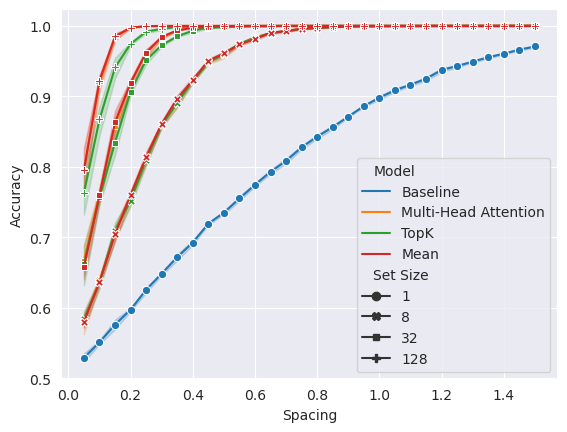

In [17]:
sns.lineplot(data=results, x="Spacing", y="Accuracy", hue="Model", style="Set Size", markers=True, dashes=False)

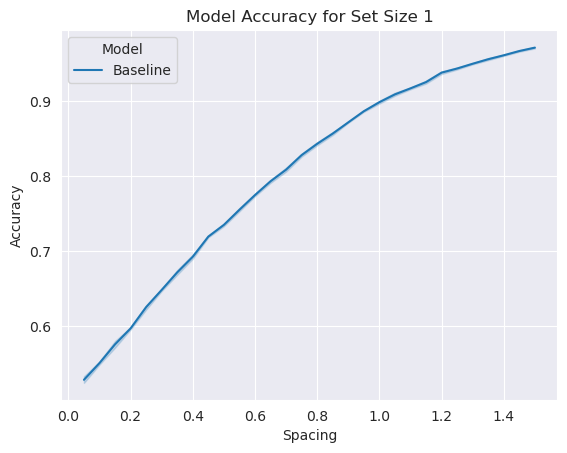

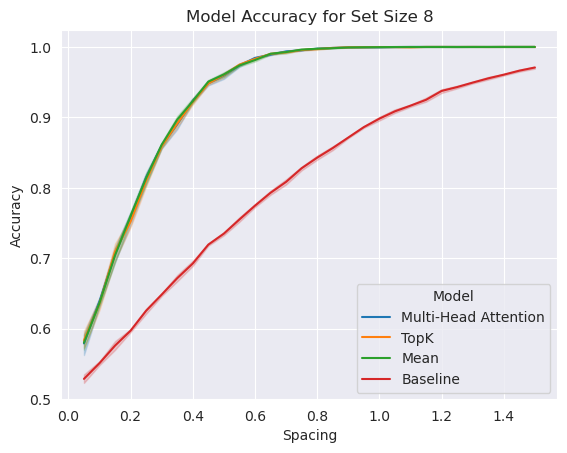

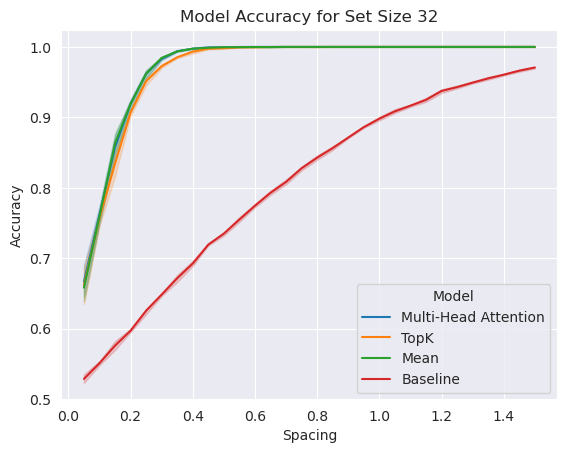

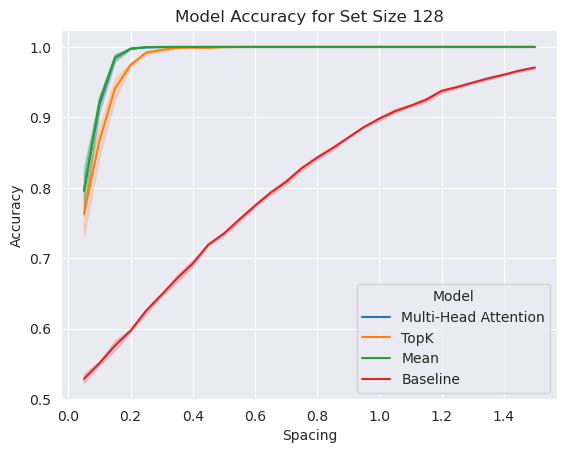

In [18]:
for set_size in pd.unique(results["Set Size"]):
    r = results[results["Set Size"] == set_size]
    b = results[results["Model"] == "Baseline"]
    
    r = pd.concat([r, b], ignore_index=True)
    
    sns.lineplot(data=r, x="Spacing", y="Accuracy", hue="Model", markers=True, dashes=False)
    plt.title(f"Model Accuracy for Set Size {set_size}")
    plt.show()